Deciding between a celebrity look alike with photo classifier and something slightly easier with gender and race classification

[LFW Website](http://vis-www.cs.umass.edu/lfw/#information) <br />
[LFW Dataset and Other Papers](https://paperswithcode.com/dataset/lfw) <br />
[Tensorflow Documentation](https://www.tensorflow.org/datasets/catalog/lfw) <br />
[CONV2D Explanation](https://towardsdatascience.com/conv2d-to-finally-understand-what-happens-in-the-forward-pass-1bbaafb0b148) <br />
[Image Classification Explanation](https://www.analyticsvidhya.com/blog/2020/02/learn-image-classification-cnn-convolutional-neural-networks-3-datasets/) <br />
[LFW Cleaning Data](https://datagen.tech/guides/image-datasets/lfw-dataset/) 


## Rolling list of links papers that helped me:

[BOLD5000](https://www.nature.com/articles/s41597-019-0052-3) 

## Libraries

In [1]:
#!pip install tensorflow-datasets
#!pip install tensorflow
#!pip install -U jupyter
#!pip install -U  tensorflow
#!pip install -U  sklearn
#!pip install -U -q segmentation-models

#!pip install -q tensorflow==2.1
#!pip install -q keras==2.3.1
#!pip install -q tensorflow-estimator==2.1.
#!pip install tensorflow

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from sklearn import datasets
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Rescaling
from tensorflow.keras.utils import to_categorical
import requests
import glob
import os
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(os.getcwd())
print('Training on',DEVICE)
seed = 9090

C:\Users\quort\OneDrive\Desktop\Data-Analyst-Portfolio\[In-Progress] Neural Network for Celebrity Face Classifier (LFW)
Training on cuda


## Loading Dataset

Gonna be using sklearn instead of tfds to download data now.

In [3]:
#example_txt = 'https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt'

#r = requests.get(example_txt)
#with open('lfw_attributes.txt', 'wb') as f:
#    f.write(r.content)

In [4]:
ds = []

DATASET_PATH ="lfw-deepfunneled/"
ATTRIBUTES_PATH = "/lfw_attributes.txt/"

In [5]:
for path in glob.glob(os.path.join(DATASET_PATH ,"**", "*.jpg")):
    person = path.split("\\")[-2]
    ds.append({"person":person, "path": path})

ds = pd.DataFrame(ds)
ds = ds.groupby("person").filter(lambda x: len(x) > 20)
ds.head(10)

person                                               path
222  Alejandro_Toledo  lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
223  Alejandro_Toledo  lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
224  Alejandro_Toledo  lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
225  Alejandro_Toledo  lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
226  Alejandro_Toledo  lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
227  Alejandro_Toledo  lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
228  Alejandro_Toledo  lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
229  Alejandro_Toledo  lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
230  Alejandro_Toledo  lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
231  Alejandro_Toledo  lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...

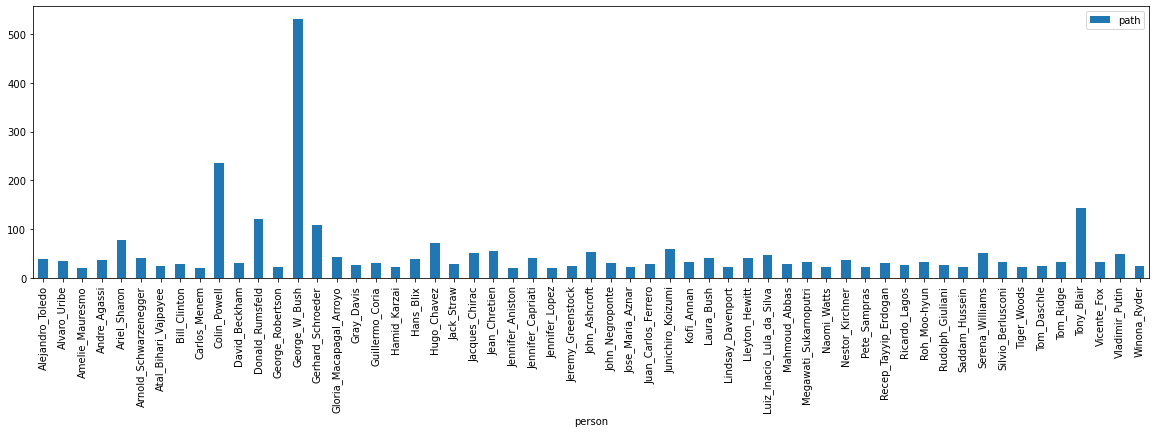

In [6]:
ds.groupby("person").count()[:200].plot(kind='bar', figsize=(20,5))

In [8]:
unique_labels = ds['person'].unique()
d = dict(enumerate(map(str, unique_labels)))
d = dict((v,k) for k,v in d.items())

In [9]:
ds['person_num'] = ds['person'].map(d)
ds

person                                               path  \
222    Alejandro_Toledo  lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...   
223    Alejandro_Toledo  lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...   
224    Alejandro_Toledo  lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...   
225    Alejandro_Toledo  lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...   
226    Alejandro_Toledo  lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...   
...                 ...                                                ...   
13042      Winona_Ryder  lfw-deepfunneled\Winona_Ryder\Winona_Ryder_002...   
13043      Winona_Ryder  lfw-deepfunneled\Winona_Ryder\Winona_Ryder_002...   
13044      Winona_Ryder  lfw-deepfunneled\Winona_Ryder\Winona_Ryder_002...   
13045      Winona_Ryder  lfw-deepfunneled\Winona_Ryder\Winona_Ryder_002...   
13046      Winona_Ryder  lfw-deepfunneled\Winona_Ryder\Winona_Ryder_002...   

       person_num  
222             0  
223             0  
224             0  
225             0  
226             0  
...           ...  
13042          56  
13043          56  
13044          56  
13045          56  
13046          56  

[2923 rows x 3 columns]

## Exploring Data (Using TFDS)

In [304]:
ds, ds_info = tfds.load('lfw',split='train', with_info = True, as_supervised = True )
ds_info.features
#Some preprocessing steps are done as the image is normalized to be 250x250

C:\Users\quort\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


FeaturesDict({
    'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
    'label': Text(shape=(), dtype=tf.string),
})

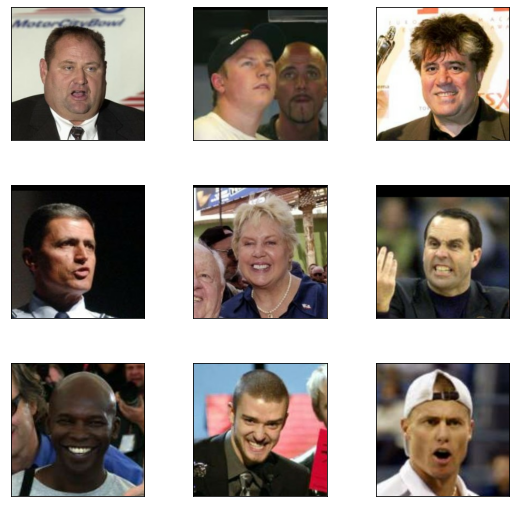

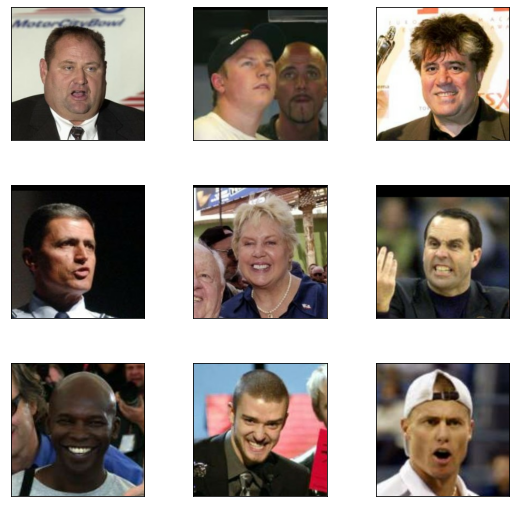

In [5]:
tfds.show_examples(ds, ds_info)

In [6]:
df = tfds.as_dataframe(ds, ds_info)
head = df.head()

In [7]:
head['image']

0    [[[207, 209, 195], [207, 209, 195], [208, 210,...
1    [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
2    [[[255, 255, 255], [255, 255, 255], [255, 255,...
3    [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
4    [[[5, 0, 4], [3, 0, 2], [1, 0, 0], [2, 0, 1], ...
Name: image, dtype: object

In [8]:
head['label']

0        b'Tom_Amstutz'
1     b'Kimi_Raikkonen'
2    b'Pedro_Almodovar'
3          b'John_Rosa'
4        b'Jane_Rooney'
Name: label, dtype: object

In [12]:
counts = labels.explode().value_counts()
counts = counts.to_frame()
counts = counts.rename({ "label": "counts"}, axis = 1)
counts.index.name = "label"
counts.reset_index(inplace = True)
counts = counts[counts['counts'] > 5]
counts
#top 311 people have 5+ pictures

label  counts
0                b'George_W_Bush'     530
1                 b'Colin_Powell'     236
2                   b'Tony_Blair'     144
3              b'Donald_Rumsfeld'     121
4            b'Gerhard_Schroeder'     109
..                            ...     ...
306            b'Charlton_Heston'       6
307            b'Ricardo_Sanchez'       6
308  b'Jose_Manuel_Durao_Barroso'       6
309             b'Robert_De_Niro'       6
310            b'Mike_Krzyzewski'       6

[311 rows x 2 columns]

In [13]:
df1 = df[df['label'].isin(counts['label'])]
df1 = df1.reset_index()
df1['label']

0              b'Pedro_Almodovar'
1            b'Justin_Timberlake'
2               b'Lleyton_Hewitt'
3                   b'Ian_Thorpe'
4       b'Christine_Todd_Whitman'
                  ...            
5420                b'Jay_Garner'
5421           b'Renee_Zellweger'
5422             b'Mahmoud_Abbas'
5423             b'Hosni_Mubarak'
5424           b'Antonio_Palocci'
Name: label, Length: 5425, dtype: object

In [14]:
for example in ds:
    label, image = example
    if label == counts['label'][1]:
        print(label)
    break

In [9]:
df.head()

image               label
0  [[[207, 209, 195], [207, 209, 195], [208, 210,...      b'Tom_Amstutz'
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   b'Kimi_Raikkonen'
2  [[[255, 255, 255], [255, 255, 255], [255, 255,...  b'Pedro_Almodovar'
3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...        b'John_Rosa'
4  [[[5, 0, 4], [3, 0, 2], [1, 0, 0], [2, 0, 1], ...      b'Jane_Rooney'

In [10]:
labels = df['label']

In [15]:
# train_images = []
# train_labels = []
# i = 0
# #inefficient way of doing it but I wanted to make it work first
# for example in ds:
#     label, image = example
#     for c in counts['label']:
#         i += 1
#         print(i)
#         if label == c:
#             train_images.append(image.numpy())
#             train_labels.append(label.numpy())
#             continue

    

In [16]:
# len(train_images)

In [17]:
# len(train_labels)

## Data Processing

#### other loading methods

In [345]:
#Other data loading method
lfw_train, lfw_test = train_test_split(ds, test_size = 0.2, random_state = seed)
lfw_train, lfw_val =  train_test_split(lfw_train, test_size = 0.2, random_state = seed)
lfw_train = lfw_train.reset_index().drop("index",1)
lfw_test = lfw_test.reset_index().drop("index",1)
print(len(set(lfw_train.person).intersection(set(lfw_test.person))))
print(len(set(lfw_test.person) - set(lfw_train.person)))

#K folds if I want
kfold = KFold(n_splits = 10, shuffle = True, random_state = seed)

57
0


#### loading methods

In [10]:
batch_size = 32
img_height = 250
img_width = 250

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13233 files belonging to 5749 classes.
Using 10587 files for training.
Found 13233 files belonging to 5749 classes.
Using 2646 files for validation.


In [12]:
class_names = train_ds.class_names
class_names_test =val_ds.class_names
print(len(train_ds.class_names))
print(len(val_ds.class_names))

5749
5749


In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 250, 250, 3)
(32,)


Normally, this step would be done by me but LFW has the following in the README.txt

"Each image is a 250x250 jpg, detected and centered using the openCV implementation of Viola-Jones face detector. The cropping region returned by the detector was then automatically enlarged by a factor of 2.2 in each dimension to capture more of the head and then scaled to a uniform size."

## Modelings

In [14]:
#Performance 
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Preliminary Models
#We are working with a 250 x 250 pictures with 3 color channels
#Choosing a simple 1 input layer and 2 hidden layers for now. Will optimize later.
#I will be using relu function for activation,  mean squared error for loss, and adam for optimizer

$$ N_h = \frac{N_s} {(\alpha * (N_i + N_o))} $$
$ Ni $= number of input neurons. <br />
$No$ = number of output neurons.<br />
$Ns$ = number of samples in training data set.<br />
$α $= an arbitrary scaling factor usually 2-10.

[Link](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw)

[Refreshment on the Math](https://arxiv.org/pdf/1603.07285v1.pdf)

In [15]:
num_classes = 5749

model = Sequential()
model.add(Rescaling(1./255))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (250,250,3)))
model.add(MaxPool2D(pool_size=(1,1)))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(1,1)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='softmax'))
model.compile(optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
107/331 [========>.....................] - ETA: 14:18 - loss: -413317758976.0000 - accuracy: 0.0000e+00

## Load Dataset (OLD)

In [3]:
ds, ds_info = tfds.load('lfw',split='train', with_info = True, as_supervised = True )
test =  (ds, ds_info)
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    full_name='lfw/0.1.0',
    description="""
    Labeled Faces in the Wild:
            A Database for Studying Face Recognition in
            Unconstrained Environments
    """,
    homepage='http://vis-www.cs.umass.edu/lfw',
    data_path='~\\tensorflow_datasets\\lfw\\0.1.0',
    file_format=tfrecord,
    download_size=172.20 MiB,
    dataset_size=180.28 MiB,
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('label', 'image'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=13233, num_shards=2>,
    },
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts,

## Data Processing (OLD) [Description inside]

This consists of the old data processing that I conducted. I originally downloaded the dataset from TFDS and used that dataset to explore and produce modeling. However, after some many hours trying to input the data into the CNN, I eventually decided to use an actual dataset within my computer instead of the TFDS dataset. There are some reasons why TFDS made it hard to use. 

**New Method:** Download the dataset and keep them within local files instead of downloading the dataset via TFDS.

1. TFDS downloaded the dataset as a tfds dataset which meant I was working with a PrefetchDataset instead of a more normalized version
2. Editing a TensorSpec proved to be difficult. When attempting to use .map and a dictionary to convert the byte values of the labels (strings which of the individual persons), tensorflow would go into graph mode and block all numpy functionalities to work.
3. Since I was having difficulty sectioning the labels, the model would not work with a string output instead of a categorical integer
4. I did not tackle the sectioning of the dataset either. So, even if I were to run the model, some people with <5 pictures would be included and would not have been helpful for identification. 

In [21]:
unique_labels = df['label'].unique()
d = dict(enumerate(map(str, unique_labels)))
d = dict((v,k) for k,v in d.items())
d

{"b'Tom_Amstutz'": 0,
 "b'Kimi_Raikkonen'": 1,
 "b'Pedro_Almodovar'": 2,
 "b'John_Rosa'": 3,
 "b'Jane_Rooney'": 4,
 "b'Mike_Brey'": 5,
 "b'Keith_Brown'": 6,
 "b'Justin_Timberlake'": 7,
 "b'Lleyton_Hewitt'": 8,
 "b'Thomas_Wilkens'": 9,
 "b'Ian_Thorpe'": 10,
 "b'Christine_Todd_Whitman'": 11,
 "b'Yekaterina_Guseva'": 12,
 "b'George_W_Bush'": 13,
 "b'Martha_Stewart'": 14,
 "b'Jesse_James'": 15,
 "b'John_Abizaid'": 16,
 "b'Tim_Henman'": 17,
 "b'Pieter_Bouw'": 18,
 "b'Lance_Armstrong'": 19,
 "b'John_Marburger'": 20,
 "b'Al_Gore'": 21,
 "b'Donald_Rumsfeld'": 22,
 "b'Andy_Roddick'": 23,
 "b'Jeremy_Greenstock'": 24,
 "b'Junko_Tabei'": 25,
 "b'Richard_Haass'": 26,
 "b'Paul_Coppin'": 27,
 "b'Dinah_Turner'": 28,
 "b'Guenter_Verheugen'": 29,
 "b'Princess_Elisabeth'": 30,
 "b'Doug_Collins'": 31,
 "b'Larry_Hahn'": 32,
 "b'Natalie_Cole'": 33,
 "b'Valery_Giscard_dEstaing'": 34,
 "b'Gregory_Hines'": 35,
 "b'Mitt_Romney'": 36,
 "b'Ahmed_Chalabi'": 37,
 "b'Lucio_Gutierrez'": 38,
 "b'Bridgette_Wilson-Sampr

In [100]:
#had to do it without filtering to see if it works
train_ds, val_ds, test_ds= tfds.load('lfw', split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'], as_supervised = True)

labels = []
for label, image in train_ds:
    #labels.append(float(d[str(label.numpy())]))
    #print(float(d[str(label.numpy())]))
    print(label)
    break
train_ds

tf.Tensor(b'Tom_Amstutz', shape=(), dtype=string)


<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(250, 250, 3), dtype=tf.uint8, name=None))>

In [106]:
print(list(d.keys()))

["b'Tom_Amstutz'", "b'Kimi_Raikkonen'", "b'Pedro_Almodovar'", "b'John_Rosa'", "b'Jane_Rooney'", "b'Mike_Brey'", "b'Keith_Brown'", "b'Justin_Timberlake'", "b'Lleyton_Hewitt'", "b'Thomas_Wilkens'", "b'Ian_Thorpe'", "b'Christine_Todd_Whitman'", "b'Yekaterina_Guseva'", "b'George_W_Bush'", "b'Martha_Stewart'", "b'Jesse_James'", "b'John_Abizaid'", "b'Tim_Henman'", "b'Pieter_Bouw'", "b'Lance_Armstrong'", "b'John_Marburger'", "b'Al_Gore'", "b'Donald_Rumsfeld'", "b'Andy_Roddick'", "b'Jeremy_Greenstock'", "b'Junko_Tabei'", "b'Richard_Haass'", "b'Paul_Coppin'", "b'Dinah_Turner'", "b'Guenter_Verheugen'", "b'Princess_Elisabeth'", "b'Doug_Collins'", "b'Larry_Hahn'", "b'Natalie_Cole'", "b'Valery_Giscard_dEstaing'", "b'Gregory_Hines'", "b'Mitt_Romney'", "b'Ahmed_Chalabi'", "b'Lucio_Gutierrez'", "b'Bridgette_Wilson-Sampras'", "b'Tom_Daschle'", "b'Jean_Carnahan'", "b'Megawati_Sukarnoputri'", "b'Tony_Blair'", "b'John_Allen_Muhammad'", "b'Jose_Viegas_Filho'", "b'Andres_Pastrana'", "b'Kofi_Annan'", "b'Howa

In [118]:
keys_tensor = tf.constant(list(d.keys()))
vals_tensor = tf.constant(list(d.values()))
table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
    default_value=-1)
print(train_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(250, 250, 3), dtype=tf.uint8, name=None))>


In [183]:
def convert(label, image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image, label = convert2(label, image)
    return image, label

def convert2(image, label):
    #label = tf.reshape( label, ( 1, ) )
    label = table.lookup(label)
    #label = tf.reshape( label, () )
    return image, label

In [189]:
a, b = train_ds_1.element_spec
b

TensorSpec(shape=(None,), dtype=tf.int32, name=None)

In [185]:
train_ds_1.element_spec =train_ds_1.element_spec.map(convert2)

AttributeError: 'tuple' object has no attribute 'map'

In [166]:
BATCH_SIZE = 32

train_ds_1 = (train_ds
            .cache()
            .map(convert1)
            .batch(BATCH_SIZE))

val_ds_1 = (val_ds
            .cache()
            .map(convert1)
            .batch(BATCH_SIZE))


Tensor("args_1:0", shape=(250, 250, 3), dtype=uint8)
Tensor("Reshape:0", shape=(1,), dtype=string)


AttributeError: in user code:

    File "<ipython-input-139-97495c169150>", line 4, in convert1  *
        image, label = convert2(label, image)
    File "<ipython-input-165-48b711af6d37>", line 9, in convert2  *
        print(table.lookup(label).numpy())

    AttributeError: 'Tensor' object has no attribute 'numpy'


In [164]:
for i,j in train_ds_1.take(1):
    print(i)
    print(j)

tf.Tensor(
[[[[0.8117648  0.8196079  0.76470596]
   [0.8117648  0.8196079  0.76470596]
   [0.81568635 0.8235295  0.7686275 ]
   ...
   [0.8431373  0.854902   0.78823537]
   [0.8431373  0.854902   0.78823537]
   [0.8431373  0.854902   0.78823537]]

  [[0.8117648  0.8196079  0.76470596]
   [0.8117648  0.8196079  0.76470596]
   [0.81568635 0.8235295  0.7686275 ]
   ...
   [0.8431373  0.854902   0.78823537]
   [0.8431373  0.854902   0.78823537]
   [0.8431373  0.854902   0.78823537]]

  [[0.8117648  0.8196079  0.76470596]
   [0.8117648  0.8196079  0.76470596]
   [0.81568635 0.8235295  0.7686275 ]
   ...
   [0.8431373  0.854902   0.78823537]
   [0.8431373  0.854902   0.78823537]
   [0.8431373  0.854902   0.78823537]]

  ...

  [[0.11764707 0.1137255  0.09803922]
   [0.1137255  0.10980393 0.09411766]
   [0.1137255  0.10980393 0.09411766]
   ...
   [0.09411766 0.08627451 0.09019608]
   [0.09019608 0.08235294 0.08627451]
   [0.09019608 0.08235294 0.08627451]]

  [[0.11764707 0.1137255  0.098039